# In this notebook I use pre-trained DeiT model for End-To-End Tea Leaf Disease Detection WebApp With Streamlit.

# Step 1 | Installing and importing libraries

In [2]:
!pip install split-folders

In [3]:
!pip install timm 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 6.2 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [4]:
# framewrork 
import torch
import torch.nn as nn
import torchvision
import timm

# preprocessing and loading datasets
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# training
import torch.optim as optimizer
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from transformers import Trainer, TrainingArguments

# train, val, test split
import pathlib
import splitfolders

# visualizations 
import seaborn as sns
import matplotlib.pyplot as plt

# class weights
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


# metrics and callback
import torch.nn.functional as F
from torchmetrics import Accuracy
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
from torch.optim.lr_scheduler import CosineAnnealingLR
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import RichProgressBar, LearningRateMonitor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
import os

2025-09-06 12:58:41.067238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757163521.242672      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757163521.290362      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
print("CUDA available:", torch.cuda.is_available())
print("Current device:", device)
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

CUDA available: True
Current device: cuda
Device name: Tesla P100-PCIE-16GB


# Step 2 | Splitting and loading dataset

In [7]:
BATCH_SIZE = 8
IMAGE_SIZE = 224 
EPOCHS = 20
PATCH_SIZE = 16
NUM_CLASSES = 7
LR = 5e-5

# Standard ImageNet normalization
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

In [8]:
# path of the dataset
path = "/kaggle/input/tealeafbd-tea-leaf-disease-detection/teaLeafBD/teaLeafBD"
# splitting train, val, test
splitfolders.ratio(input=path, output="LeafDisease", seed=1337, ratio=(0.8, 0.1, 0.1))

Copying files: 5276 files [00:36, 143.86 files/s]


In [9]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.RandomResizedCrop(IMAGE_SIZE),  
                                       transforms.RandomHorizontalFlip(),                     
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),   
                                       transforms.RandomRotation(15),
                                       transforms.Normalize(mean=imagenet_mean,  # mean from ImageNet
                                                            std=imagenet_std),  # std from ImageNet
                                       transforms.Resize((IMAGE_SIZE,IMAGE_SIZE))])

validation_transforms = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize(mean=imagenet_mean,  # mean from ImageNet
                                                                 std=imagenet_std),  # std from ImageNet
                                            transforms.Resize((IMAGE_SIZE,IMAGE_SIZE))])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize(mean=imagenet_mean,  # mean from ImageNet
                                                                 std=imagenet_std),  # std from ImageNet
                                            transforms.Resize((IMAGE_SIZE,IMAGE_SIZE))])

In [10]:
train_set = datasets.ImageFolder(root="LeafDisease/train", transform=train_transforms)
print("Train", "\n", train_set)

train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)

Train 
 Dataset ImageFolder
    Number of datapoints: 4218
    Root location: LeafDisease/train
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=(-0.1, 0.1))
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
           )


In [11]:
class_names = train_set.classes

In [12]:
validation_set = datasets.ImageFolder(root="LeafDisease/val", transform=validation_transforms)
print("Validation", "\n", validation_set)

validation_loader = DataLoader(dataset=validation_set, batch_size=BATCH_SIZE, shuffle=False )

Validation 
 Dataset ImageFolder
    Number of datapoints: 524
    Root location: LeafDisease/val
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
           )


In [13]:
test_set = datasets.ImageFolder(root="LeafDisease/test", transform=test_transforms)
print("Test", "\n", validation_set)

test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False )

Test 
 Dataset ImageFolder
    Number of datapoints: 524
    Root location: LeafDisease/val
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
           )


#### Here we have 4218 images for training and both validation and test have 524 images. I used ImageNet mean and std values beacuse the ViT model which I uses was trained on  ImageNet

In [14]:
# function to denormalize
def denormalize(img, mean=imagenet_mean, std=imagenet_std):
    # img: tensor [C,H,W]
    mean = torch.tensor(mean).view(3,1,1)
    std  = torch.tensor(std).view(3,1,1)
    return img * std + mean

In [15]:
images, labels = next(iter(train_loader))

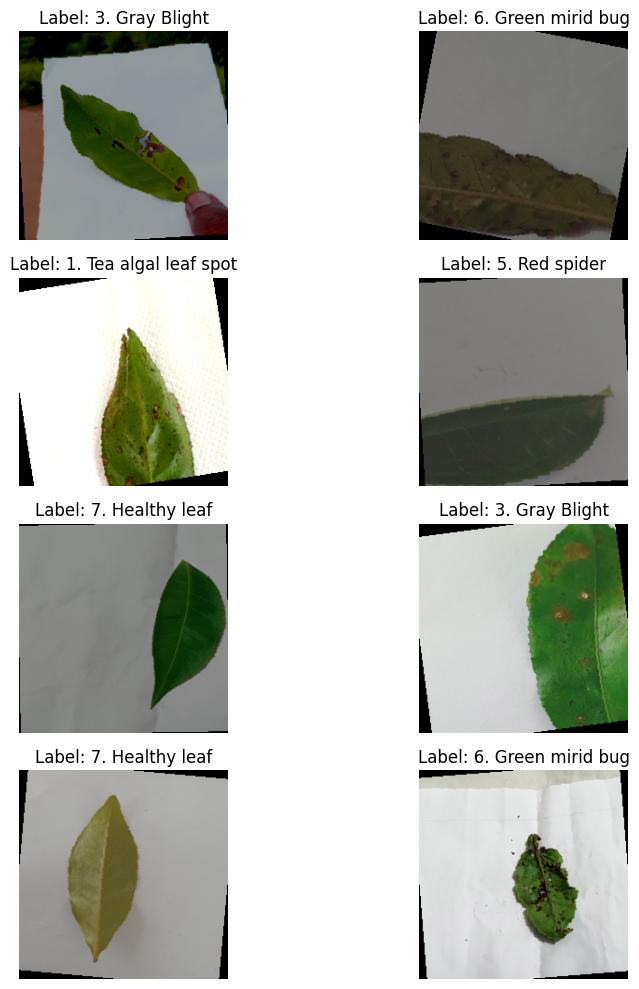

In [16]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
for i in range(8):
    img = denormalize(images[i])   # reverse normalization
    ax = axs[i//2, i%2]
    ax.imshow(img.permute(1,2,0).clamp(0,1))
    
    label_idx = labels[i].item() # scaler labels
    
    ax.set_title(f"Label: {class_names[label_idx]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


# Step 3 | Class weights

$$\text{weight}_i = \frac{\text{n\_samples}}{\text{n\_classes} \times \text{n\_samples\_in\_class}_i}$$

In [17]:
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(train_set.targets),
                                     y=train_set.targets)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Step 4 | DeiT

**What is DeiT?**

DeiT (Data-efficient Image Transformer) is a vision model introduced by Facebook AI that adapts the Transformer architecture (originally designed for NLP tasks) to image classification. Unlike convolutional neural networks (CNNs), which use convolutions to capture local patterns, DeiT processes an image as a sequence of patches (similar to words in a sentence) and learns global relationships between them using self-attention.

Key Ideas of DeiT:

Patch-based input – An image is divided into fixed-size patches (e.g., 
16
×
16
16×16), which are linearly embedded into vectors.

Transformer backbone – The model applies multiple layers of multi-head self-attention to learn contextual relationships between patches.

Distillation token – Unlike standard Vision Transformers, DeiT introduces a special token that learns from both the dataset and a teacher model (usually a CNN) during training. This improves efficiency and accuracy.

Data efficiency – Traditional Vision Transformers required extremely large datasets (like JFT-300M) to work well. DeiT was designed to perform competitively using only ImageNet (1M images), making it much more practical.

**Why we use DeiT:**

Strong performance with fewer training images.

Handles global dependencies better than CNNs.

Efficient and scalable for different image classification tasks.

**Why Use Focal Loss?**

In standard image classification, we often use Cross-Entropy Loss. However, when the dataset is imbalanced (some classes have many more samples than others) or when certain examples are harder to classify, Cross-Entropy can cause the model to focus too much on the easy/majority classes and ignore the minority/hard samples.

**Key Benefits:**

Class imbalance handling – prevents the model from being biased toward majority classes.

Focus on hard examples – encourages the network to pay more attention to samples it struggles with.

Improved generalization – especially useful in datasets where some categories are rare or much harder to distinguish.

In [18]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss)
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

In [19]:
class DeiT(pl.LightningModule):
    def __init__(self,num_classes=NUM_CLASSES, lr=LR, class_weights=class_weights, weight_decay=0.05):
        super().__init__()
        self.save_hyperparameters()

        # Step 1 | pre-trained model
        self.model = timm.create_model(
                    "deit_small_patch16_224",
                    pretrained=True,
                    num_classes=NUM_CLASSES)
        
        # step 2 | defining metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc   = Accuracy(task="multiclass", num_classes=num_classes)

        # Step 3 | criterion 
        if class_weights is not None:
            self.register_buffer("class_weights", torch.tensor(class_weights, dtype=torch.float))
            self.criterion = FocalLoss(alpha=self.class_weights, gamma=2)
        else:
            self.criterion = FocalLoss(gamma=2)

    # step 4 | output
    def forward(self, x):
        return self.model(x)

    
    def training_step(self, batch, batch_idx):
        # Step 1 | x and y
        x, y = batch
        # Step 2 | getting logits
        output = self(x) # uses forward
        # Step 3 | calculating loss with weights
        loss = self.criterion(output, y)
        # step 4 | log training loss
        self.train_acc.update(output, y)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    # printing loss and accuracy of trainset
    def on_train_epoch_end(self):
        # Access the logged metrics and print them
        train_acc = self.trainer.callback_metrics.get("train_acc")
        train_loss = self.trainer.callback_metrics.get("train_loss")
        self.print(f"[Epoch {self.current_epoch}] Train Accuracy: {train_acc:.4f} | Train Loss: {train_loss:.4f}")

    def validation_step(self, batch, batch_idx):
        # Step 1 | x and y
        x, y = batch
        # Step 2 | getting output
        output = self(x) # uses forward
        # Step 3 | calculating loss with weights
        loss = self.criterion(output, y)
        # step 4 | log training loss
        self.val_acc.update(output, y)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", self.val_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    # printing loss and accuracy of validationset
    def on_validation_epoch_end(self):
        # Access the logged metrics and print them
        val_acc = self.trainer.callback_metrics.get("val_acc")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        self.print(f"[Epoch {self.current_epoch}] Val Accuracy: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay)
    
        scheduler = CosineAnnealingLR(
            optimizer,
            T_max=10 )
    
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "epoch"}}


In [20]:
model = DeiT(num_classes=NUM_CLASSES, lr=LR, class_weights=class_weights, weight_decay=0.05)

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [21]:
#  Checkpoint
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",          
    mode="max",               
    save_top_k=1,             
    filename="best-deit-{epoch:02d}-{val_acc:.4f}"
)

# EarlyStopping 
early_stopping_callback = EarlyStopping(
    monitor="val_acc",
    patience=5,                 
    mode="max"
)

#  LearningRateMonitoring
lr_monitor = LearningRateMonitor(logging_interval="step")


# Trainer
trainer = pl.Trainer(
    max_epochs=15,
    accelerator="gpu", devices=1,
    precision=16,                                
    callbacks=[checkpoint_callback, early_stopping_callback, lr_monitor],
    log_every_n_steps=10,
    deterministic=True                            # reproducibility
)


In [22]:
# training
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=validation_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[Epoch 0] Val Accuracy: 0.0000 | Val Loss: 4.2661


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 0] Val Accuracy: 0.7939 | Val Loss: 0.2919
[Epoch 0] Train Accuracy: 0.6460 | Train Loss: 0.5824


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 1] Val Accuracy: 0.7538 | Val Loss: 0.3875
[Epoch 1] Train Accuracy: 0.7643 | Train Loss: 0.3310


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 2] Val Accuracy: 0.8359 | Val Loss: 0.1699
[Epoch 2] Train Accuracy: 0.7923 | Train Loss: 0.2927


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 3] Val Accuracy: 0.7805 | Val Loss: 0.2320
[Epoch 3] Train Accuracy: 0.8153 | Train Loss: 0.2344


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 4] Val Accuracy: 0.8282 | Val Loss: 0.1974
[Epoch 4] Train Accuracy: 0.8265 | Train Loss: 0.2351


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 5] Val Accuracy: 0.8874 | Val Loss: 0.1444
[Epoch 5] Train Accuracy: 0.8490 | Train Loss: 0.1918


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 6] Val Accuracy: 0.8893 | Val Loss: 0.1602
[Epoch 6] Train Accuracy: 0.8642 | Train Loss: 0.1645


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 7] Val Accuracy: 0.8721 | Val Loss: 0.1398
[Epoch 7] Train Accuracy: 0.8784 | Train Loss: 0.1522


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 8] Val Accuracy: 0.8950 | Val Loss: 0.1215
[Epoch 8] Train Accuracy: 0.8810 | Train Loss: 0.1438


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 9] Val Accuracy: 0.8931 | Val Loss: 0.1231
[Epoch 9] Train Accuracy: 0.8879 | Train Loss: 0.1456


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 10] Val Accuracy: 0.8931 | Val Loss: 0.1231
[Epoch 10] Train Accuracy: 0.8872 | Train Loss: 0.1385


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 11] Val Accuracy: 0.8893 | Val Loss: 0.1239
[Epoch 11] Train Accuracy: 0.8943 | Train Loss: 0.1285


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 12] Val Accuracy: 0.8950 | Val Loss: 0.1217
[Epoch 12] Train Accuracy: 0.8869 | Train Loss: 0.1412


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 13] Val Accuracy: 0.9065 | Val Loss: 0.1253
[Epoch 13] Train Accuracy: 0.8850 | Train Loss: 0.1482


Validation: |          | 0/? [00:00<?, ?it/s]

[Epoch 14] Val Accuracy: 0.8511 | Val Loss: 0.1608
[Epoch 14] Train Accuracy: 0.8722 | Train Loss: 0.1493


# Step 5 | Saving the best model

In [23]:
# saving model
best_model_path = checkpoint_callback.best_model_path
model = DeiT.load_from_checkpoint(best_model_path)

torch.save(model.model.state_dict(), "/kaggle/working/deit_best.pth")

# Stp 6 | Evaluation

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
model = timm.create_model("deit_small_patch16_224", pretrained=False, num_classes=NUM_CLASSES)

model.load_state_dict(torch.load("/kaggle/working/deit_best.pth", map_location=device))

model = model.to(device)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [27]:
def evaluate_with_heatmap(model, dataloader, dataset_name="Dataset"):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    # Compute metrics
    accuracy = MulticlassAccuracy(num_classes=NUM_CLASSES).to(device)
    precision = MulticlassPrecision(num_classes=NUM_CLASSES, average="macro").to(device)
    recall = MulticlassRecall(num_classes=NUM_CLASSES, average="macro").to(device)
    f1 = MulticlassF1Score(num_classes=NUM_CLASSES, average="macro").to(device)

    accuracy.update(torch.tensor(all_preds).to(device), torch.tensor(all_labels).to(device))
    precision.update(torch.tensor(all_preds).to(device), torch.tensor(all_labels).to(device))
    recall.update(torch.tensor(all_preds).to(device), torch.tensor(all_labels).to(device))
    f1.update(torch.tensor(all_preds).to(device), torch.tensor(all_labels).to(device))

    acc = accuracy.compute().item()
    prec = precision.compute().item()
    rec = recall.compute().item()
    f1_score = f1.compute().item()

    print(f"\n===== {dataset_name} Metrics =====")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1_score:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    # Confusion Matrix Heatmap
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


===== Train Metrics =====
Accuracy:  0.9017
Precision: 0.8730
Recall:    0.9017
F1-score:  0.8830

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       334
           1       0.83      0.85      0.84       404
           2       0.95      0.81      0.88       810
           3       0.76      0.96      0.85       485
           4       0.87      0.96      0.91       412
           5       0.97      0.85      0.91      1025
           6       0.93      0.95      0.94       748

    accuracy                           0.89      4218
   macro avg       0.87      0.90      0.88      4218
weighted avg       0.90      0.89      0.89      4218



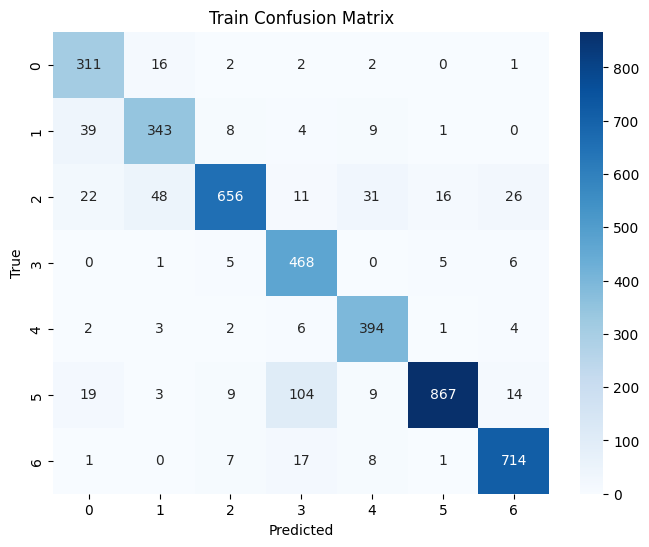

In [28]:
# evaluate on Train
evaluate_with_heatmap(model, train_loader, "Train")


===== Validation Metrics =====
Accuracy:  0.9124
Precision: 0.8897
Recall:    0.9124
F1-score:  0.8972

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        41
           1       0.69      0.82      0.75        50
           2       0.96      0.80      0.88       101
           3       0.78      0.97      0.87        60
           4       0.98      0.98      0.98        51
           5       0.99      0.89      0.94       128
           6       0.97      1.00      0.98        93

    accuracy                           0.91       524
   macro avg       0.89      0.91      0.90       524
weighted avg       0.92      0.91      0.91       524



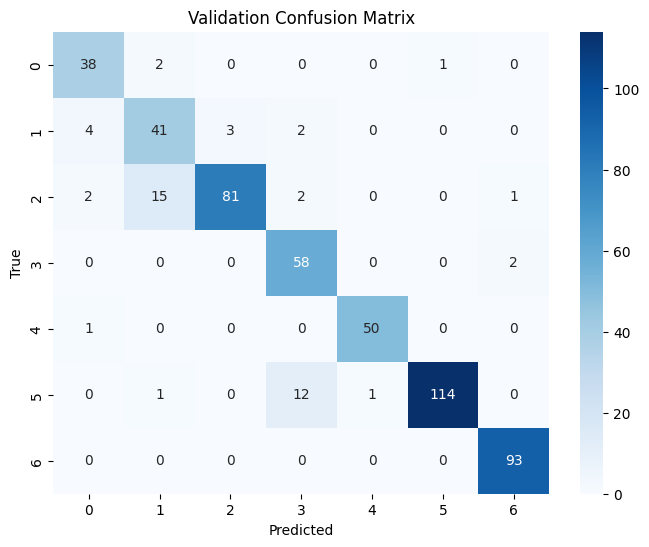

In [29]:
# evaluate on Validation
evaluate_with_heatmap(model, validation_loader, "Validation")


===== Test Metrics =====
Accuracy:  0.8900
Precision: 0.8688
Recall:    0.8900
F1-score:  0.8761

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        43
           1       0.69      0.87      0.77        52
           2       0.97      0.83      0.89       102
           3       0.81      0.94      0.87        62
           4       0.85      0.90      0.88        52
           5       0.97      0.88      0.92       129
           6       0.99      0.98      0.98        94

    accuracy                           0.89       534
   macro avg       0.87      0.89      0.88       534
weighted avg       0.90      0.89      0.89       534



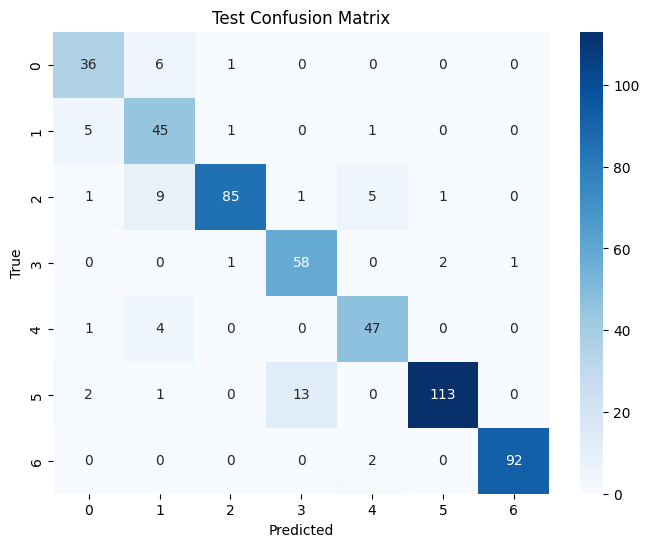

In [30]:
# evaluate on Test
evaluate_with_heatmap(model, test_loader, "Test")